Loaded 240 images of class CHEETAH
Loaded 238 images of class OCELOT
Loaded 190 images of class CARACAL
Loaded 233 images of class LIONS
Loaded 242 images of class TIGER
Loaded 241 images of class PUMA
Loaded 1384 images total.
x shape: (1384, 224, 224, 3), y shape:(1384,)


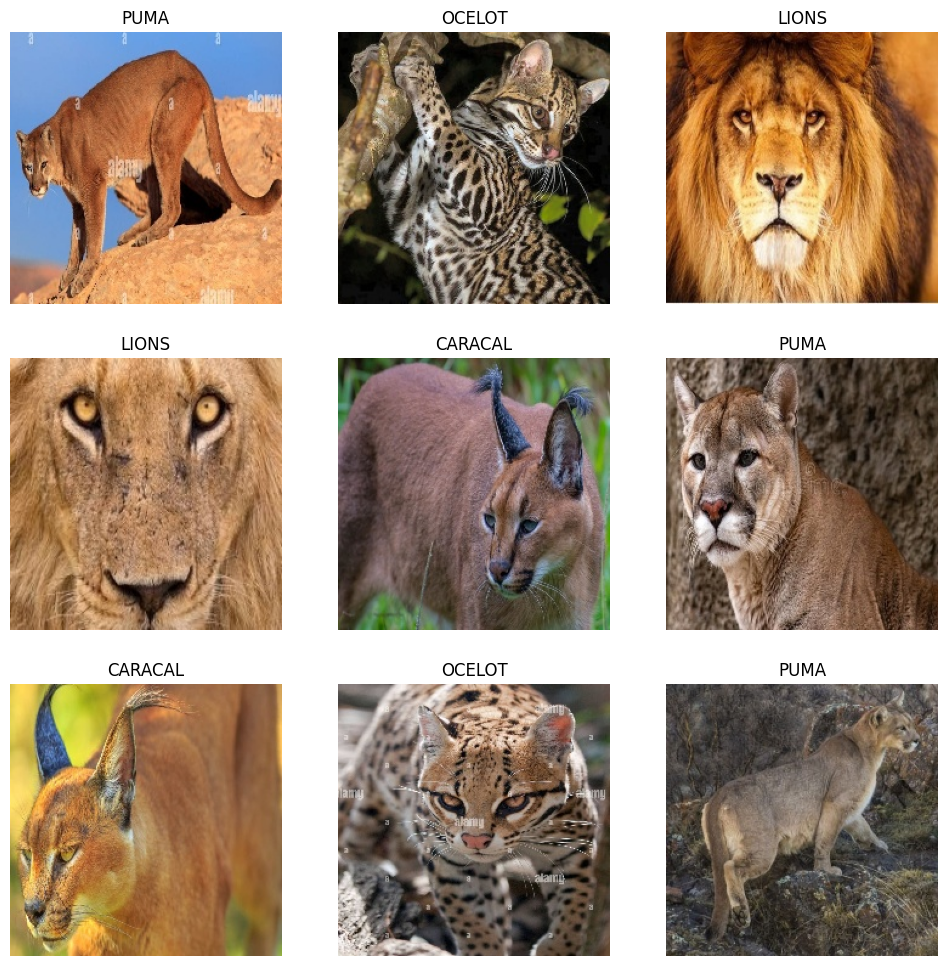

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

def load_imgs(path, folders):
    imgs = []
    labels = []
    n_imgs = 0
    for c in folders:
        # iterate over all the files in the folder
        for f in os.listdir(os.path.join(path, c).replace("/mnt/z", 'Z:\\')):
            if not f.endswith('.jpg'):
                continue
            # load the image (here you might want to resize the img to save memory)
            im = Image.open(os.path.join(path, c, f)).copy()
            imgs.append(im)
            labels.append(c)
        print('Loaded {} images of class {}'.format(len(imgs) - n_imgs, c))
        n_imgs = len(imgs)
    print('Loaded {} images total.'.format(n_imgs))
    return imgs, labels

def plot_sample(imgs, labels, nrows=4, ncols=4, resize=None):
    # create a grid of images
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    # take a random sample of images
    indices = np.random.choice(len(imgs), size=nrows*ncols, replace=False)
    for ax, idx in zip(axs.reshape(-1), indices):
        ax.axis('off')
        # sample an image
        ax.set_title(labels[idx])
        im = imgs[idx]
        if isinstance(im, np.ndarray):
            im = Image.fromarray(im)  
        if resize is not None:
            im = im.resize(resize)
        ax.imshow(im, cmap='gray')


# map class -> idx
label_to_idx = {
    'CHEETAH':0,
    'OCELOT': 1,
    'CARACAL':2,
    'LIONS': 3,
    'TIGER':4,
    'PUMA':5
}

idx_to_label = {
    0:'CHEETAH',
    1:'OCELOT',
    2:'CARACAL',
    3:'LIONS',
    4:'TIGER',
    5: 'PUMA'
}

def make_dataset(imgs, labels, label_map, img_size):
    x = []
    y = []
    n_classes = len(list(label_map.keys()))
    for im, l in zip(imgs, labels):
        # preprocess img
        x_i = im.resize(img_size)
        x_i = np.asarray(x_i)
        
        # encode label
        y_i = label_map[l]
        
        x.append(x_i)
        y.append(y_i)
    return np.array(x).astype('float32'), np.array(y)

def save_model(model, filepath):
    """
    Save PyTorch model to a file.

    Args:
        model: PyTorch model to be saved.
        filepath (str): Path to save the model.
    """
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath, device='cpu'):
    """
    Load PyTorch model from a file.

    Args:
        model_class: Model class (e.g., ConvNet) to instantiate.
        filepath (str): Path from which to load the model.
        device (str): Device to move the model to (default is 'cpu').

    Returns:
        model: Loaded PyTorch model.
    """
    model = model_class() # change it to your own model class
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    return model

# Create new Dataset objects for the training and test datasets
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)


imgs, labels = load_imgs('./Dataset', ['CHEETAH' ,'OCELOT', 'CARACAL', 'LIONS', 'TIGER', 'PUMA']) #TODO CHANGE ME!!
X, y = make_dataset(imgs, labels, label_to_idx, (224,224))
print('x shape: {}, y shape:{}'.format(X.shape, y.shape))
plot_sample(imgs, labels, 3, 3, resize=(224, 224))

cuda
Epoch [1/101], Train Acc: 16.98, Val Acc: 19.49
Epoch [11/101], Train Acc: 54.92, Val Acc: 29.96
Epoch [21/101], Train Acc: 79.49, Val Acc: 30.69
Epoch [31/101], Train Acc: 87.90, Val Acc: 25.99
Epoch [41/101], Train Acc: 97.74, Val Acc: 29.24
Epoch [51/101], Train Acc: 95.57, Val Acc: 32.49
Epoch [61/101], Train Acc: 100.00, Val Acc: 29.96
Epoch [71/101], Train Acc: 100.00, Val Acc: 31.41
Epoch [81/101], Train Acc: 100.00, Val Acc: 30.69
Epoch [91/101], Train Acc: 100.00, Val Acc: 28.88
Epoch [101/101], Train Acc: 100.00, Val Acc: 30.32


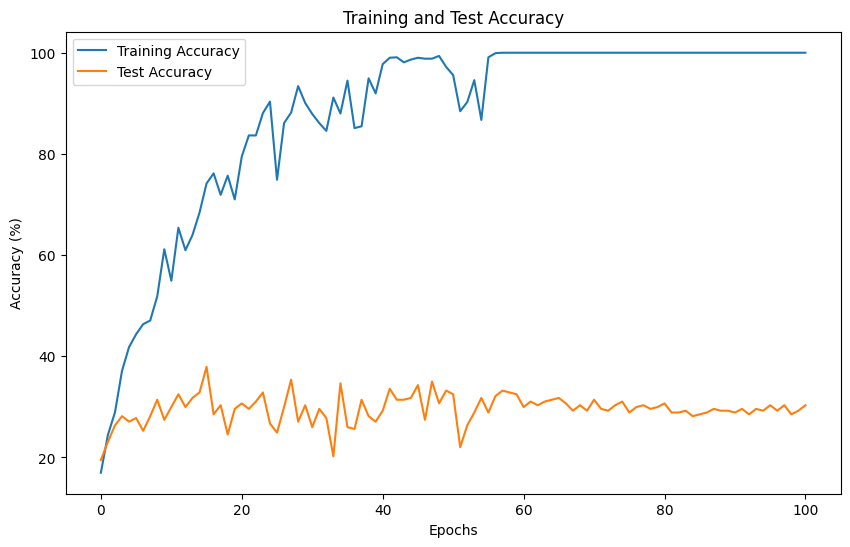

In [2]:
################### Task 1 ###################
# general context setting
CONFIGS = {'seed': 20020309, 
          'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
          'batch_size': 32,
          'epochs': 1 + 100, # 100 
          'learning_rate':  0.001}

np.random.seed(CONFIGS['seed'])
torch.manual_seed(CONFIGS['seed'])
print(CONFIGS['device'])


from torch import nn
from torch.nn import functional as F
class FFNN(nn.Module):
    def __init__(self, _in_features, _num_classes):
        super(FFNN, self).__init__()
        # 3 layers
        self.fc1 = nn.Linear(_in_features, 128)  # input layer with 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # hidden layer with 64 hidden units
        self.fc3 = nn.Linear(64, _num_classes)  # output layer with num_classes units

    def forward(self, _x):
        # pass through layers with GELU activation
        _x = F.gelu(self.fc1(_x))
        _x = F.gelu(self.fc2(_x))
        _x = self.fc3(_x) # no activation for the output layer, output raw logits
        return _x


def get_input(_f_features=None):
    """_features is a function"""
    from sklearn.preprocessing import OneHotEncoder
    def safe_copy(*args):
        return map(lambda el: el.copy(), *args)
    
    _x, _y = safe_copy(make_dataset(imgs, labels, label_to_idx, (224,224))) # from init given cell
    _x = _x / 255.0 # normalizing images
    
    _feats = None
    if _f_features is not None:
        _feats = _f_features(_x)
        
    _x = _x.reshape(_x.shape[0], -1) # 1D vector image
    _encoder = OneHotEncoder(sparse_output=False, categories="auto")
    _y = _encoder.fit_transform(_y.reshape(-1, 1))
    return _x, _y, _feats 


def get_loads(_x, _y, _ratio, _permute=False, _transform=None):
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader
    _data = [(_x[i], _y[i]) for i in range(len(_x))]
    _train_data, _test_data = train_test_split(
        _data, train_size=_ratio, random_state=CONFIGS['seed']
    )
    # prepare data for training DataLoader
    _train_dataset = Dataset(_train_data, transform=_transform) # transform makes sense only on training data
    _test_dataset = Dataset(_test_data)
    # create dataLoader for both training and test datasets
    _batch_size = CONFIGS["batch_size"]
    _train_loader = DataLoader(_train_dataset, batch_size=_batch_size, shuffle=True)
    _test_loader = DataLoader(_test_dataset, batch_size=_batch_size, shuffle=True)
    return _train_loader, _test_loader


def calculate_accuracy(_y_true, _y_pred):
    _predicted_classes = torch.argmax(_y_pred, dim=1)
    _true_classes = torch.argmax(_y_true, dim=1)
    _correct = (_predicted_classes == _true_classes).sum().item()
    return _correct


def load_to_device(*args):
    return map(lambda el: el.to(CONFIGS["device"]), args)


# plot training and test accuracies
def plot_train_test(_train_acc, _test_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(_train_acc, label='Training Accuracy')
    plt.plot(_test_acc, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
    
def train(_model, _criterion, _optimizer, _loaders):
    import copy
    _train_loader, _test_loader = _loaders
    # train the model and get accuracies
    _train_acc = []
    _test_acc = []
    _best_test_accuracy = 0
    _best_model = None
    for _epoch in range(CONFIGS["epochs"]):
        _model.train()
        _running_loss = 0
        _correct = 0
        _total = 0
        for _inputs, _labels in _train_loader:
            _inputs, _labels = load_to_device(_inputs, _labels)
            _optimizer.zero_grad()
            _outputs = _model(_inputs)
            _loss = _criterion(_outputs, _labels.float())
            _loss.backward()
            _optimizer.step()
            _running_loss += _loss.item()
            # compute accuracy
            _correct += calculate_accuracy(_labels, _outputs)
            _total += _labels.size(0)
            
        _train_accuracy = 100 * _correct / _total
        _train_acc.append(_train_accuracy)

        # validation
        _model.eval()
        _test_correct = 0
        _test_total = 0
        with torch.no_grad():
            for _inputs, _labels in _test_loader:
                _inputs, _labels = load_to_device(_inputs, _labels)
                _outputs = _model(_inputs)
                _test_correct += calculate_accuracy(_labels, _outputs)
                _test_total += _labels.size(0)
                
        _test_accuracy = 100 * _test_correct / _test_total
        _test_acc.append(_test_accuracy)
        if _test_accuracy > _best_test_accuracy:
            _best_test_accuracy = _test_accuracy
            # Save best model
            _best_model = copy.deepcopy(_model)

        if _epoch % 10 == 0:
            print(f"Epoch [{_epoch+1}/{CONFIGS['epochs']}]", 
                  f"Train Acc: {_train_accuracy:.2f}",
                  f"Val Acc: {_test_accuracy:.2f}",
                 sep=", ")
    return _train_acc, _test_acc, _best_model


x, y, _ = get_input()
train_loader, test_loader = get_loads(x, y, 0.8)
model = FFNN(x.shape[1], len(label_to_idx)).to(CONFIGS["device"])
criterion = nn.BCEWithLogitsLoss() # better for classification with discrete values
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIGS["learning_rate"])
train_acc, test_acc, best_model = train(model, criterion, optimizer, (train_loader, test_loader))
save_model(best_model, 'best_ffnn.pth')
test_acc_t1 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

Epoch [1/101], Train Acc: 15.81, Val Acc: 20.58
Epoch [11/101], Train Acc: 28.18, Val Acc: 28.52
Epoch [21/101], Train Acc: 31.07, Val Acc: 27.44
Epoch [31/101], Train Acc: 31.44, Val Acc: 28.16
Epoch [41/101], Train Acc: 31.44, Val Acc: 27.80
Epoch [51/101], Train Acc: 32.70, Val Acc: 27.80
Epoch [61/101], Train Acc: 33.15, Val Acc: 28.52
Epoch [71/101], Train Acc: 32.79, Val Acc: 29.24
Epoch [81/101], Train Acc: 33.42, Val Acc: 28.52
Epoch [91/101], Train Acc: 34.15, Val Acc: 27.44
Epoch [101/101], Train Acc: 34.60, Val Acc: 30.69


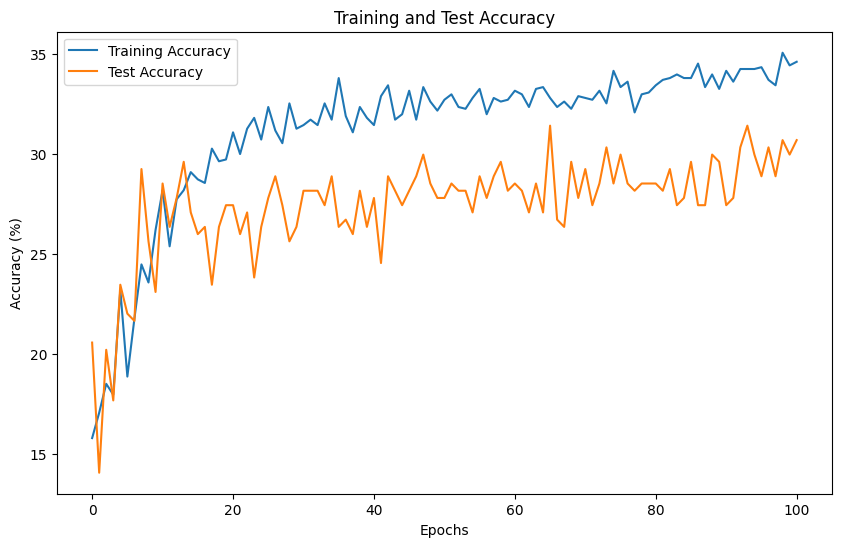

In [3]:
################### Task 1 BONUS ###################
def get_features(_imgs):
    _feats = []
    _r, _g, _b = 0, 1, 2
    get_mean_var = lambda img, idx : (np.mean(img[:,:,idx]), np.var(img[:,:,idx]))
    for _img in _imgs:
        _r_mean_var = get_mean_var(_img, _r)
        _g_mean_var = get_mean_var(_img, _g)
        _b_mean_var = get_mean_var(_img, _b)
        _feats.append([*_r_mean_var, *_g_mean_var, *_b_mean_var])
    return np.array(_feats)


x, y, feats = get_input(get_features)
train_loader, test_loader = get_loads(feats, y, 0.8)
model = FFNN(feats.shape[1], len(label_to_idx)).to(CONFIGS["device"])
criterion = nn.BCEWithLogitsLoss() # better for classification with discrete values
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIGS["learning_rate"])
train_acc, test_acc, best_model = train(model, criterion, optimizer, (train_loader, test_loader))
# save_model(best_model, 'best_ffnn.pth')
test_aug_acc_t1 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

In [4]:
################### Task 2 ###################
class RecipeCNN(nn.Module):
    def __init__(self, num_classes):
        super(RecipeCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# normalize each pixel of each channel so that the range is [0, 1], 
# by applying the min-max normlaization (division by 255)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)  # Convert numpy array to torch tensor
X_norm = X_tensor / 255.0  # Normalize
# Permute dimensions from [batch, height, width, channels] to [batch, channels, height, width]
X_norm = X_norm.permute(0, 3, 1, 2)  # Permute dimensions

# prepare data for training
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y_tensor, test_size=0.2, random_state=SEED
)

from torch.utils.data import TensorDataset, DataLoader
# prepare data for training using TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# create dataLoader for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# init model, loss function criterion and optimizer
model = RecipeCNN(len(label_to_idx)).to(device)
criterion = nn.CrossEntropyLoss() # better for classification with discrete values
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def calculate_accuracy(labels, outputs):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item()

# train the model and get accuracies
train_acc = []
val_acc = []
best_val_accuracy = 0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_correct += calculate_accuracy(labels, outputs)
            val_total += labels.size(0)
            
    val_accuracy = 100 * val_correct / val_total
    val_acc.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}')

# for statistical comparison 
val_acc_t2 = val_acc.copy()
        
plot_train_test(train_acc, val_acc)

# 5. STATISTICAL COMPARISON
from scipy.stats import ttest_rel
# using val_acc_t1, val_acc_t2 collected before
t_stat, p_value = ttest_rel(val_acc_t1[:EPOCHS], val_acc_t2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of the result
if p_value < 0.05:
    print("There is a statistically significant difference between the performances of T1 and T2.")
else:
    print("There is no statistically significant difference between the performances of T1 and T2.")
    
#--------------------------------------------------------
# 6. apply image manipulation and augmentation techniques
#--------------------------------------------------------
import torchvision.transforms as transforms
class AugmentedDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, labels, permutation=False, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32)
        if permutation:
            self.data = self.data.permute(0, 3, 1, 2)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        if self.transform:
            x = transforms.functional.to_pil_image(x)
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

# Define the transformations
augmentation_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),  # Ensure all images are resized to the correct input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

X, y = make_dataset(imgs, labels, label_to_idx, (224,224))
X = X / 255.0
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_encoded = encoder.fit_trasnform(y.reshape(-1, 1)).toarray()

# init model, loss function criterion and optimizer
model = RecipeCNN(len(label_to_idx)).to(device)
criterion = nn.CrossEntropyLoss() # better for classification with discrete values
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def calculate_accuracy(labels, outputs):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item()

# train the model and get accuracies
train_acc = []
val_acc = []
best_val_accuracy = 0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_correct += calculate_accuracy(labels, outputs)
            val_total += labels.size(0)
            
    val_accuracy = 100 * val_correct / val_total
    val_acc.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}')

# for statistical comparison 
val_acc_aug_t2 = val_acc.copy()
        
# plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# 5. STATISTICAL COMPARISON
from scipy.stats import ttest_rel
# using val_acc_t2, val_acc_aug_t2 collected before
t_stat, p_value = ttest_rel(val_acc_t2, val_acc_aug_t2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of the result
if p_value < 0.05:
    print("There is a statistically significant difference between the performances of T2 and T2 AUGMENTED.")
else:
    print("There is no statistically significant difference between the performances of T2 and T2 AUGMENTED.")

NameError: name 'device' is not defined

In [ ]:
################### Task 2 BONUS ###################
from sklearn.model_selection import ParameterGrid
import copy
print(device)

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64]
}

# Function to perform training and validation
def train_and_evaluate_model(params):
    model = RecipeCNN(len(label_to_idx)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    best_accuracy = 0
    for epoch in range(10):  # Shorter number of epochs for grid search
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = copy.deepcopy(model.state_dict())

    return best_accuracy, best_model

# Grid search execution
best_overall_accuracy = 0
best_overall_params = None
best_model_weights = None

for grid_params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {grid_params}")
    accuracy, model_weights = train_and_evaluate_model(grid_params)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_overall_accuracy:
        best_overall_accuracy = accuracy
        best_overall_params = grid_params
        best_model_weights = model_weights

# Output the best parameters and set the best model
print(f"Best Parameters: {best_overall_params}")
model.load_state_dict(best_model_weights)
torch.save(model.state_dict(), 'best_model.pth')

In [ ]:
################### Task 3 ###################
import torch.nn as nn
import torchvision.models as models
print(device)

class CuttedModifiedVGG19(nn.Module):
    def __init__(self, num_classes, cut_point):
        super(CuttedModifiedVGG19, self).__init__()
        # Load the pre-trained VGG19 model
        vgg19 = models.vgg19(pretrained=True)
        # you can see the VGG19 detailed architecutre
        print(vgg19)
        # Extract the feature extractor part of VGG19 (all layers except the classifier)
        # TODO specify your cut layer
        self.cut_value = {1: 28, 2: None}
        self.features =  nn.Sequential(*list(vgg19.features.children())[:self.cut_value[cut_point]]) #vgg19.features
        
        # check your new model based on the cut
        print(self.features)
        
       
        for param in self.features.parameters():
            param.requires_grad = False
            
        # TODO Initialize your layers
        # additional classifier layers similar to VGG's Block 6
        if cut_point == 1:
            flat_dimension = 100352
        elif cut_point == 2:
            flat_dimension = 25088
        self.classifiers = nn.Sequential(
            nn.Linear(flat_dimension, 128),  # The dimension here depends on the input size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Pass input through VGG19 feature extractor
        x = self.features(x)
        
        # TODO Forward your layers
        x = x.view(x.size(0), -1)  # Flatten the features:
        x = self.classifiers(x)  # Pass through the classifier
        
        return x
    
num_classes = 6  # Adjust based on the actual number of your classes
cut_point = 2    # Choose 1 or 2 based on desired cut

model = CuttedModifiedVGG19(num_classes=num_classes, cut_point=cut_point)
model.to(device)  # Move model to GPU if available

# Example setup for loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifiers.parameters(), lr=0.001)  # Only optimize classifier parameters


# TODO Training LOOP
# train the model and get accuracies
train_acc = []
val_acc = []
best_val_accuracy = 0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            
    val_accuracy = 100 * val_correct / val_total
    val_acc.append(val_accuracy)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}')


In [ ]:
################### Task 3 Bonus ###################
